In [1]:
import sys
import time
import pprint
import pandas as pd
from lsst.afw.image.exposure import ExposureF
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import firefly_client.plot as ffplt

In [2]:
!setup display_firefly

Configuration:
* query - Data selection query
* maxref - Maximum # references to list (< 0 to list all)
* nplt - Number of datasets to display
* iplt1 - Number of datasets to skip when plotting
* showMask - 1 to show # mask bits, 2 to also show the mask names and colors

In [3]:
class PlotSpec:
    '''
    PlotSpec specifies how a plot is to be constructed.
        transparency - Mask transparency in range [0, 100]
        showSources - show all identified sources
        showCandidates - show calibration candidates
        showUsed - show sources used in calibration
        showRejected - show candidates rejected in calibration
    It is constructed from a strings with dash-separated attributes, e.g. 'tr80-srccan':
        trII where II is the transparency, e.g. 0, 80, 100
        src - overlay all sources
        srccan - overlay all source calibration candidates
        srcuse - overlay all source calibrations candadates used
        srcrej - overlay all source calibration candidates not used
    '''
    __slots__ = ['transparency', 'showSources', 'showCandidates', 'showUsed', 'showRejected']
    def __init__(self, scfg):
        self.transparency = 100.0
        self.showSources = False
        self.showCandidates = False
        self.showUsed = False
        self.showRejected = False
        for sfld in scfg.split('-'):
            if sfld == '': pass
            elif sfld[0:2] == 'tr': self.transparency = float(sfld[2:])
            elif sfld == 'src'  : self.showSources = True
            elif sfld == 'srccan'  : self.showCandidates = True
            elif sfld == 'srcuse'  : self.showUsed = True
            elif sfld == 'srcrej'  : self.showRejected = True
            else:
                raise Exception(f"ERROR: PlotSpec: Invalid field {sfld} in config {scfg}")
    def need_source(self):
        if self.showSources: return True

class Config:
    '''
            type - Type of data to process: raw, calexp or src
           qtype - Type of data to query. If blank, typ is used.
            repo - Repository location.
     collections - Names of the collections to query
           query - Query used to select the data.
           nskip - Number of datasets to skip.
          maxref - Maximum # datasets to process. Use -1 for all.
         maxplot - Maximum # of datasets for which plots should be made. Use -1 for all.
       plotspecs - List of string specifiers for each plot. See PlotSpec. One plot for each.
      showSchema - Count for which source schema are displayed
  showCandidates - Count for which source schema are displayed.
        showMask - Count for which source schema are displayed.
    '''
    __slots__ = ['type', 'qtype', 'repo', 'collections', 'query', 'nskip', 'maxproc', 'maxplot', 'plotspecs',
                 'showSchema', 'showCandidates', 'showMask']

    def __init__(self):
        self.type = 'raw'
        self.qtype = ''
        self.repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo'
        self.collections = ['LSSTCam-imSim/raw/all']
        self.query = 'visit=238'
        self.nskip = 0
        self.maxproc = -1
        self.maxplot = 1
        self.plotspecs = ['']
        self.showSchema = 0
        self.showCandidates = 1
        self.showMask = 0
    
    def __str__(self):
        sout = ''
        for nam in self.__slots__:
            sout += f"{nam:>15}: {getattr(self, nam)}\n"
        return sout
    
    def query_type(self):
        if len(self.qtype): return self.qtype
        return self.type

    def visit_string(self):
        svis = 'visit'
        if self.type == 'raw': svis = 'exposure'
        return svis
        
    def query_visit_string(self):
        svis = 'visit'
        if self.query_type() == 'raw': svis = 'exposure'
        return svis
    
    def plot_specs(self):
        psps = []
        for spsp in self.plotspecs:
            psps.append(PlotSpec(spsp))
        return psps 





In [4]:

showSrc = 0
showFig = 1
useff = False
drawCandidates = True

cfg = Config()
%run -i config.py
print('Job configuration:')
print(cfg)




Job configuration:
           type: calexp
          qtype: raw
           repo: /global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo
    collections: ['LSSTCam-imSim/raw/all', 'u/dladams/dtest03-pipccd-vis238-wq050-cori01-cvmfs-bt30-002/20220913T151325Z']
          query: visit<2000
          nskip: 0
        maxproc: 1000
        maxplot: 1
      plotspecs: []
     showSchema: 0
 showCandidates: 1
       showMask: 0



In [5]:
butler = Butler(cfg.repo, collections=cfg.collections)
reg = butler.registry
print(f"Butler repository: {cfg.repo}")
print('Butler collections:')
for cnam in cfg.collections:
    print(f"  {cnam}")

Butler repository: /global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo
Butler collections:
  LSSTCam-imSim/raw/all
  u/dladams/dtest03-pipccd-vis238-wq050-cori01-cvmfs-bt30-002/20220913T151325Z


## Query

Make the dataset query, sort by visit/exposure and detector, drop *nskip* datasets from the start and drop datasets from end
to keep list to no more than *maxproc* datasets. 

In [6]:
qtyp = cfg.query_type()
query = cfg.query
nskip = cfg.nskip
maxref = cfg.maxproc
rawrefs = reg.queryDatasets(qtyp, where=query)
refs = list(set(rawrefs))
sqvis = cfg.query_visit_string()
print(f"Querying for {qtyp} datasets.")
refs.sort(key = lambda x: (x.dataId[sqvis], x.dataId['detector']))
nrefraw = len(refs)
nref = nrefraw
if nrefraw == 0:
    print(f"No matches found for {qtyp} with query {query}")
else:
    if nskip > 0:
        print(f"Skipping {nskip} datasets")
        refs = refs[nskip:]
        nref = len(refs)
    if nref == 0:
        print(f"No matches found for {qtyp} with query {query} and nskip {nskip}")
    if maxref>=0 and nref > maxref:
        print(f"Keeping {maxref} of {nref} datasets")
        refs = refs[0:maxref]
        nref = maxref
print(f"Selected/query dataset count is {nref}/{nrefraw}")
for iref in range(nref):
    ref = refs[iref]
    print(f"{iref:5}. {ref.dataId.full}")

Querying for raw datasets.
Keeping 1000 of 8989 datasets
Selected/query dataset count is 1000/8989
    0. {band: 'r', instrument: 'LSSTCam-imSim', detector: 53, physical_filter: 'r_sim_1.4', exposure: 230}
    1. {band: 'r', instrument: 'LSSTCam-imSim', detector: 56, physical_filter: 'r_sim_1.4', exposure: 230}
    2. {band: 'r', instrument: 'LSSTCam-imSim', detector: 57, physical_filter: 'r_sim_1.4', exposure: 230}
    3. {band: 'r', instrument: 'LSSTCam-imSim', detector: 58, physical_filter: 'r_sim_1.4', exposure: 230}
    4. {band: 'r', instrument: 'LSSTCam-imSim', detector: 59, physical_filter: 'r_sim_1.4', exposure: 230}
    5. {band: 'r', instrument: 'LSSTCam-imSim', detector: 60, physical_filter: 'r_sim_1.4', exposure: 230}
    6. {band: 'r', instrument: 'LSSTCam-imSim', detector: 61, physical_filter: 'r_sim_1.4', exposure: 230}
    7. {band: 'r', instrument: 'LSSTCam-imSim', detector: 62, physical_filter: 'r_sim_1.4', exposure: 230}
    8. {band: 'r', instrument: 'LSSTCam-imSim

## Process datasets

Loop over the selected datasets.

In [7]:
typ = cfg.type
cols = cfg.collections
svis = cfg.visit_string()
iref = 0
nplt = cfg.maxplot
iplt = 0
showMask = cfg.showMask
showCandidates = cfg.showCandidates
showSchema = cfg.showSchema
dbg = 1
dpi = 200
yin = 16
xin = 20
srcdf = pd.DataFrame(columns = ['visit', 'detector', 'nsrc', 'ncan', 'ncal'])
for ref in refs:
    obj = None
    raw = None
    calexp = None
    src = None
    nsrc = None
    did = ref.dataId
    instrument = did['instrument']
    visit = did[sqvis]
    detector = did['detector']
    done = False
    for psp in cfg.plot_specs():
        # Fetch primary data.
        if not obj:
            if typ == qtyp:
                obj = butler.get(ref)
                obj.writeFits(f"{typ}.fits")
            else:
                try:
                    if typ == 'raw':
                        obj = butler.get(typ, exposure=visit, detector=detector, instrument=instrument, collections=cols)
                    else:
                        obj = butler.get(typ, visit=visit, detector=detector, instrument=instrument, collections=cols)
                except Exception as e:
                    print(f"WARNING: Unable to fetch {typ} data for detector {detector} in visit {visit}")
                    if dbg > 1: print(f"\n  {e}")
                    break
            if typ == 'src': src = obj
            styps = typ
            # Fetch secondary data.
            if typ == 'calexp' and not src:
                try:
                    src = butler.get('src', visit=visit, detector=detector, instrument=instrument, collections=cols)
                    styps = styps + ", src"
                except Exception as e:
                    print(f"WARNING: Unable to fetch secondary src data for detector {detector} in visit {visit}")
            if dbg: print(f"Processing {styps} data for detector {detector} in visit {visit} by {instrument}")
        # Display the source data.
        if src and nsrc is None:
            if showSchema:
                schnams = src.getSchema().getNames()
                print(f"Schema names [{len(schnams)}]:")
                for nam in schnams:
                    print(f"  {nam}")
                if showSchema > 0: showSchema -= 1
            nsrc = len(src)
            srccan = src[src['calib_psf_candidate']]
            nsrcc = len(srccan)
            srcuse = src[src['calib_psf_used']]
            nsrcu = len(srcuse)
            srcrej = src[src['calib_psf_candidate'] & (src['calib_psf_used'] == False)]
            #src[src['calib_psf_candidate'] & (src['calib_psf_used'] == False)]
            nsrcr = len(srcrej)
            srcdf.loc[iref] = [visit, detector, nsrc, nsrcc, nsrcu]
            if showCandidates:
                print(f"Source candidates [{nsrcc}] ('*' if used [{nsrcu}], '' if rejected [{nsrcr}])")
                print(f"{'':10} {'X':>10} {'Y':>10}")
                icc = 0
                for s in srccan:
                    x = s.getX()
                    y = s.getY()
                    use = s['calib_psf_used']
                    suf = ' *' if use else ''
                    print(f"{icc:10} {x:10.2f} {y:10.2f} {suf}")
                    icc = icc + 1
                showCandidates -= 1
        # Make plot.
        first = True
        if iref < cfg.maxplot:
            plotlims = None
            if typ == 'src': plotlims = (-0.5, 4351.5, -0.5, 4095.5)
            tref = ''
            for nam in ['visit', 'exposure', 'detector']:
                if nam in did:
                    if len(tref): tref = tref + ' '
                    sval = did[nam]
                    tref += nam.capitalize() + ' ' + str(sval)
            transp = psp.transparency
            treft = tref + f" Transparency {transp}%"
            disp = afwDisplay.Display(backend='matplotlib', frame=iplt)
            iplt += 1
            disp.scale("asinh", "zscale")
            #disp.setMaskPlaneColor('DETECTED', 'darkblue')
            disp.setMaskTransparency(transp)
            if first and showMask:
                mask = None
                try:
                    mask = obj.getMask()
                except AttributeError:
                    print(f"Type {typ} does not provide getMask")
                if mask is not None:
                    maskDict = mask.getMaskPlaneDict().items()
                    nmask = len(maskDict)
                    print(f"Dataset {iref} has {nmask} masks")
                    for imsk in maskDict:
                        nam = imsk[0]
                        bit = imsk[1]
                        col = disp.getMaskPlaneColor(nam)
                        if col is None: col = ''
                        print(f"  {nam:20} {bit:3} {col:>15}")
                showMask = 0
                first = False
            try:
                disp.mtv(obj, title=treft)
            except RuntimeError:
                print(f"Type {typ} cannot be displayed.")
                break
            fig = plt.gcf()
            axs = plt.gca()
            if dpi > 0:
                fig.set_dpi(dpi)
            fig.set_size_inches(xin, yin)
            fig.savefig(f"{typ}_v{svis}_d{detector}_tr{transp}.png")
            print(f"Displaying {treft}")
            if psp.showSources:
                with disp.Buffering():
                    for s in src:
                        disp.dot("o", s.getX(), s.getY(), size=24, ctype="turquoise")
            if psp.showCandidates:
                with disp.Buffering():
                    for s in srccan:
                        disp.dot("o", s.getX(), s.getY(), size=22, ctype="orange")
            if psp.showUsed:
                with disp.Buffering():
                    for s in srcuse:
                        disp.dot("o", s.getX(), s.getY(), size=20, ctype="yellow")
            plt.show()
            new_plotlims = axs.get_xlim() + axs.get_ylim()
            if plotlims is None or new_plotlims != plotlims:
                print(f"Plot limits: {new_plotlims}")
                plotlims = new_plotlims
    iref = iref + 1


,visit,detector,nsrc,ncan,ncal


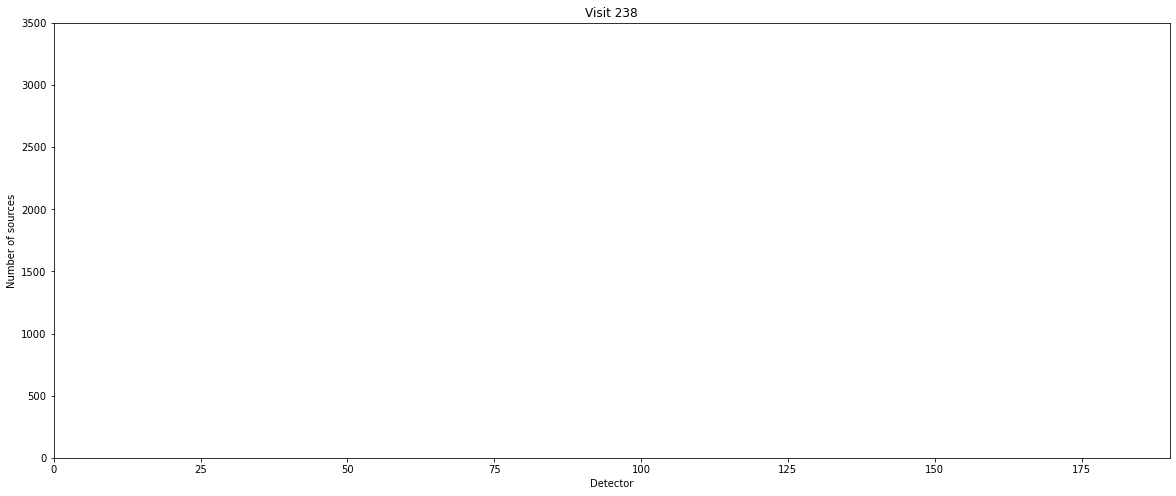

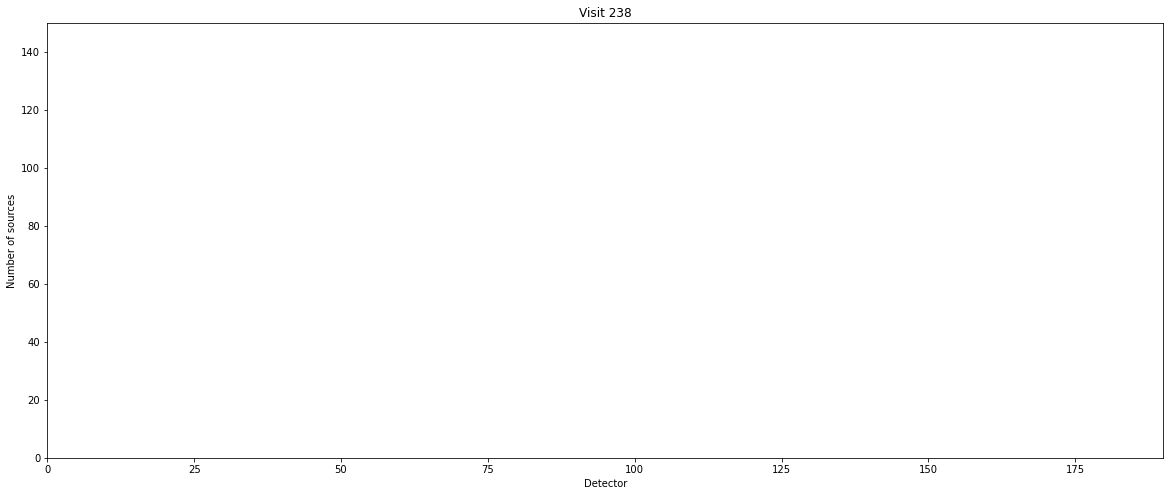

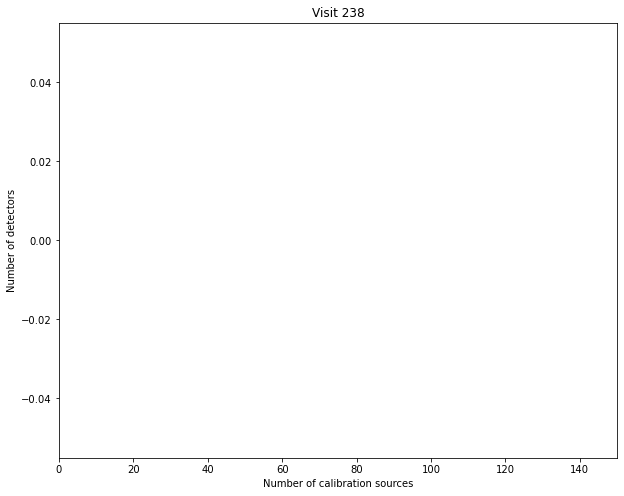

In [8]:
pd.set_option('display.max_rows', 30)
display(srcdf)

if 1:
    xmin = 0
    xmax = 190
    ymin = 0
    ymax = 3500
    fac = 1.0
    plt.figure(figsize=(fac*xin, fac*0.5*yin))
    plt.plot(srcdf.detector, srcdf.nsrc.clip(ymin,0.99*ymax), '+', color='red')
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('Detector')
    plt.ylabel('Number of sources')
    plt.title('Visit 238')
    plt.show()
    
    ymax = 150
    plt.figure(figsize=(fac*xin, fac*0.5*yin))
    plt.plot(srcdf.detector, srcdf.ncan.clip(ymin,0.99*ymax), 'x', markersize=5, color='cornflowerblue', label='Candidate')
    plt.plot(srcdf.detector, srcdf.ncal.clip(ymin,0.99*ymax), '+', markersize=10,color='darkgreen', label='Used')
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('Detector')
    plt.ylabel('Number of sources')
    plt.title('Visit 238')
    plt.show()
    
    xmax = 150
    ymax = 10
    plt.figure(figsize=(fac*0.5*xin, fac*0.5*yin))
    plt.hist(srcdf.ncal.clip(ymin,0.99*xmax), xmax//10, color='darkgreen')
    junk = plt.axis([xmin, xmax, None, None])
    plt.xlabel('Number of calibration sources')
    plt.ylabel('Number of detectors')
    plt.title('Visit 238')
    plt.show()

In [9]:
# Uncomment to show table schema
if 0:
    schnams = src.getSchema().getNames()
    print(f"Schema names [{len(schnams)}]:")
    lnams = list(schnams)
    lnams.sort()
    for nam in lnams:
        print(f"  {nam}")
    
if 1:
    lnams = tbl.colnames
    lnams.sort()
    for nam in lnams:
        print(f"  {nam}")
        
if 0:
    for row in src[0:1000]:
        print(f"{row.getX() - row['slot_Centroid_x']}")

# Uncomment to browse the source table.
#tbl.show_in_notebook()

NameError: name 'tbl' is not defined

In [ ]:
print('Done')